In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split

In [ ]:
! pip install pytorch-ignite

In [4]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
torch.manual_seed(17)
# from keras.regularizers import l2

In [3]:
import numpy as np
from torchvision import models

In [4]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
all_dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/fine_grained/CUB_200_2011/images', transform=transform)


In [5]:
train_data_len = int(len(all_dataset)*0.75)
valid_data_len = int((len(all_dataset) - train_data_len)/2)
test_data_len = int(len(all_dataset) - train_data_len - valid_data_len)
train_data, val_data_1, test_data = torch.utils.data.random_split(all_dataset, [train_data_len, valid_data_len, test_data_len])


**modification**

In [6]:
train_data_l = int(len(train_data)*0.50)
valid_data_l = int(len(train_data)*0.20)
test_data_l = int(len(train_data) - train_data_l - valid_data_l)
tr_data_2,val_2,testd=torch.utils.data.random_split(train_data, [train_data_l, valid_data_l, test_data_l])

In [39]:
test_loader=testd

In [7]:
val_data=val_data_1+val_2

In [8]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [32]:
def get_data_loaders(data_dir, batch_size):
  transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
  all_data = datasets.ImageFolder(data_dir, transform=transform)
  train_data_len = int(len(all_data)*0.70)
  valid_data_len = int((len(all_data) - train_data_len)/2)
  test_data_len = int(len(all_data) - train_data_len - valid_data_len)
  train_data_1, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
  train_loader_1 = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader_1 = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  test_loader_1 = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  return ((train_loader_1, val_loader_1, test_loader_1), all_data.classes)

In [33]:
(train_loader_1, val_loader_1, test_loader_1), classes = get_data_loaders("/content/drive/MyDrive/fine_grained/CUB_200_2011/images", 64)

In [9]:
classes=200
print(classes)
# print(len(classes))
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

200
139
51
24


In [ ]:
print(len(classes))

200


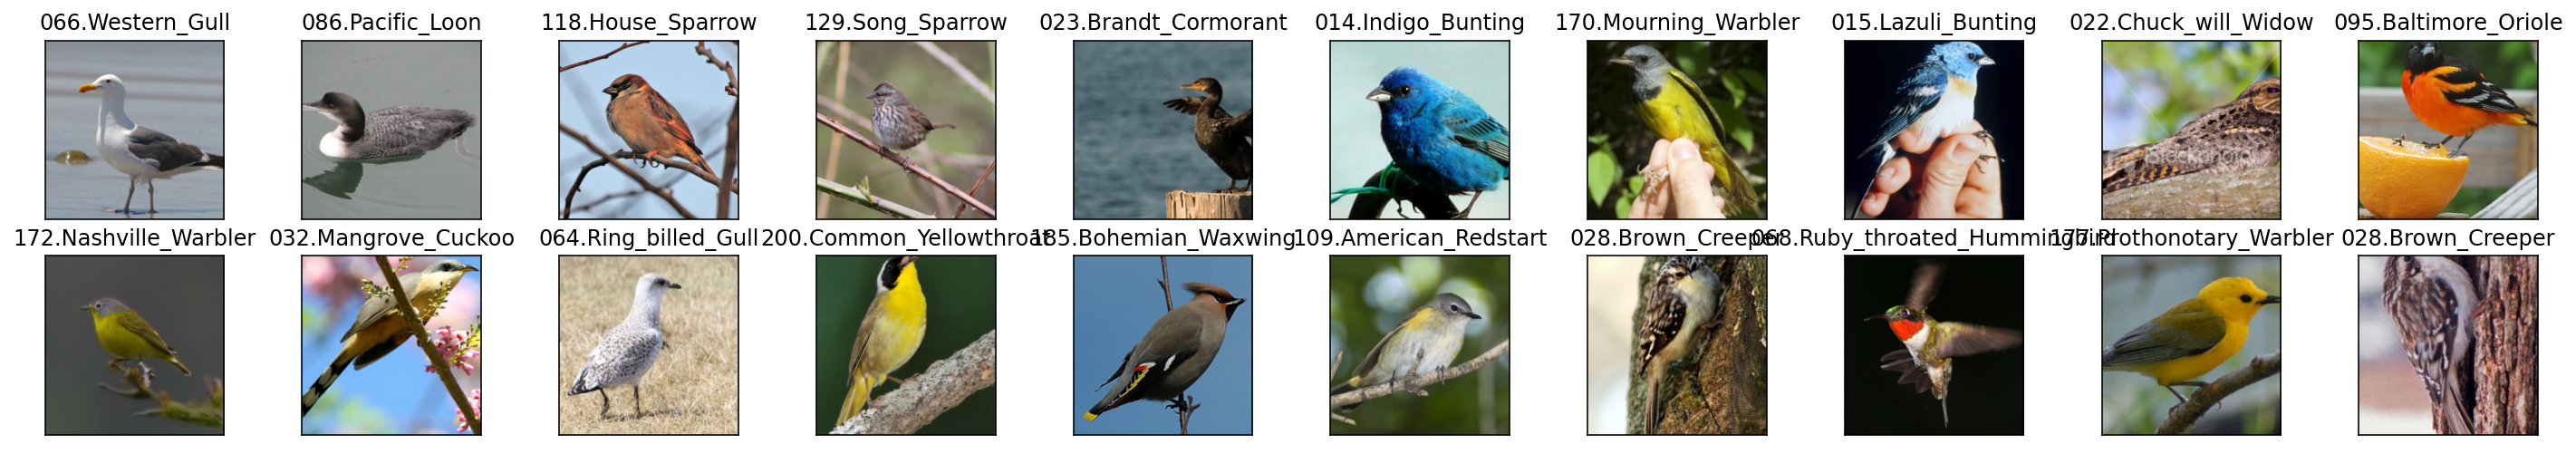

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [10]:
model = models.densenet169(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

In [11]:
print(model)
print(model.classifier.in_features) 
print(model.classifier.out_features)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, classes)
model.classifier = last_layer
if torch.cuda.is_available():
    model.cuda()
print(model.classifier.out_features)

200


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=1e-4, weight_decay=1e-5 )

In [16]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [21]:

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.contrib.handlers import ProgressBar

trainer = create_supervised_trainer(model, optimizer, criterion,device=device)
evaluator = create_supervised_evaluator(model,
                                        device=device,
                                        metrics={
                                            'accuracy': Accuracy(),
                                            'loss': Loss(criterion),
                                            'cm':ConfusionMatrix(classes)
                                            })
@trainer.on(Events.ITERATION_COMPLETED)
def log_a_dot(engine):
    print(".",end="")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print()
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
@trainer.on(Events.EPOCH_COMPLETED)   
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

In [22]:
trainer.run(train_loader, max_epochs=40)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


...........................................................................................................................................
Training Results - Epoch: 1  Avg accuracy: 0.15 Avg loss: 4.74
Validation Results - Epoch: 1  Avg accuracy: 0.12 Avg loss: 4.78
...........................................................................................................................................
Training Results - Epoch: 2  Avg accuracy: 0.37 Avg loss: 4.22
Validation Results - Epoch: 2  Avg accuracy: 0.33 Avg loss: 4.28
...........................................................................................................................................
Training Results - Epoch: 3  Avg accuracy: 0.51 Avg loss: 3.78
Validation Results - Epoch: 3  Avg accuracy: 0.46 Avg loss: 3.87
...........................................................................................................................................
Training Results - Epoch: 4  Avg accuracy: 0.61 Avg loss

State:
	iteration: 5560
	epoch: 40
	epoch_length: 139
	max_epochs: 40
	output: 0.5024029612541199
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [43]:
PATH = "/content/drive/MyDrive/fine_grained/CUB_200_2011/entire_model.pt"
torch.save(model, PATH)

In [ ]:
model = torch.load(PATH)
model.eval()

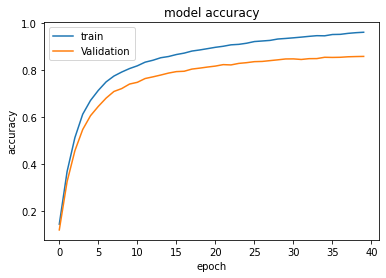

In [47]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(training_history['accuracy'])
plt.plot(validation_history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()


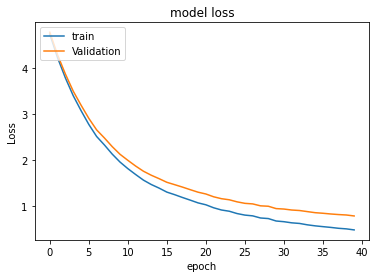

In [48]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(training_history['loss'])
plt.plot(validation_history['loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

**Test**

In [40]:
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()

for data, target in val_loader:
    if torch.cuda.is_available(): 
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 64:
      for i in range(64):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

test_loss = test_loss/len(val_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.781084

Test Accuracy of 001.Black_footed_Albatross: 92% (13/14)
Test Accuracy of 002.Laysan_Albatross: 88% (16/18)
Test Accuracy of 003.Sooty_Albatross: 100% ( 9/ 9)
Test Accuracy of 004.Groove_billed_Ani: 94% (16/17)
Test Accuracy of 005.Crested_Auklet: 100% ( 9/ 9)
Test Accuracy of 006.Least_Auklet: 90% ( 9/10)
Test Accuracy of 007.Parakeet_Auklet: 100% (13/13)
Test Accuracy of 008.Rhinoceros_Auklet: 94% (16/17)
Test Accuracy of 009.Brewer_Blackbird: 55% (10/18)
Test Accuracy of 010.Red_winged_Blackbird: 93% (15/16)
Test Accuracy of 011.Rusty_Blackbird: 73% (14/19)
Test Accuracy of 012.Yellow_headed_Blackbird: 88% (16/18)
Test Accuracy of 013.Bobolink: 90% (20/22)
Test Accuracy of 014.Indigo_Bunting: 93% (14/15)
Test Accuracy of 015.Lazuli_Bunting: 94% (17/18)
Test Accuracy of 016.Painted_Bunting: 81% (18/22)
Test Accuracy of 017.Cardinal: 100% (19/19)
Test Accuracy of 018.Spotted_Catbird: 100% (10/10)
Test Accuracy of 019.Gray_Catbird: 95% (19/20)
Test Accuracy of 020.

In [35]:
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()

for data, target in test_loader:
    if torch.cuda.is_available(): 
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 64:
      for i in range(64):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.181536

Test Accuracy of 001.Black_footed_Albatross: 100% ( 8/ 8)
Test Accuracy of 002.Laysan_Albatross: 53% ( 7/13)
Test Accuracy of 003.Sooty_Albatross: 66% ( 4/ 6)
Test Accuracy of 004.Groove_billed_Ani: 100% ( 5/ 5)
Test Accuracy of 005.Crested_Auklet: 100% ( 3/ 3)
Test Accuracy of 006.Least_Auklet: 66% ( 2/ 3)
Test Accuracy of 007.Parakeet_Auklet: 85% ( 6/ 7)
Test Accuracy of 008.Rhinoceros_Auklet: 66% ( 2/ 3)
Test Accuracy of 009.Brewer_Blackbird: 33% ( 2/ 6)
Test Accuracy of 010.Red_winged_Blackbird: 88% ( 8/ 9)
Test Accuracy of 011.Rusty_Blackbird: 60% ( 3/ 5)
Test Accuracy of 012.Yellow_headed_Blackbird: 100% ( 5/ 5)
Test Accuracy of 013.Bobolink: 100% ( 6/ 6)
Test Accuracy of 014.Indigo_Bunting: 66% ( 6/ 9)
Test Accuracy of 015.Lazuli_Bunting: 81% ( 9/11)
Test Accuracy of 016.Painted_Bunting: 100% ( 9/ 9)
Test Accuracy of 017.Cardinal: 100% ( 5/ 5)
Test Accuracy of 018.Spotted_Catbird: 100% ( 7/ 7)
Test Accuracy of 019.Gray_Catbird: 80% ( 4/ 5)
Test Accuracy of 0

In [ ]:
trainer.run(train_loader, max_epochs=50)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


......................................................................................................................................................................................................................................................
Training Results - Epoch: 1  Avg accuracy: 0.23 Avg loss: 4.55
Validation Results - Epoch: 1  Avg accuracy: 0.19 Avg loss: 4.63
......................................................................................................................................................................................................................................................
Training Results - Epoch: 2  Avg accuracy: 0.47 Avg loss: 3.90
Validation Results - Epoch: 2  Avg accuracy: 0.36 Avg loss: 4.06
......................................................................................................................................................................................................................................................
Tra